# Discover HFT trading data (50 points)
    • Add new variables to the four HFT datasets and check their visualization under PCA and t-SNE
    • Find the outliers of the HFT data in PCA and check their original samples
    • Find five nearest neighbors of each sample in the input space and its projection in the PCA subspace. How many percents of a neighbor will repeat themselves in the PCA subspace?
    • Implement SVD and use it to find the important samples in each HFT data (this is a little bit challenging)

In [2]:
import matplotlib. pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from pylab import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
def metrics (data):
    data['close_off_high'] = 2*((data['marketHigh']-data['marketClose'])/(data['marketHigh']-data['marketLow']))-1
    data['volatility'] = (data['marketHigh']-data['marketLow'])/data['marketOpen']

    return data

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def doNormalization(data, normalization_bit = 1):
  if normalization_bit:
    normalized_data = StandardScaler().fit_transform(data)
  else:
    normalized_data=MinMaxScaler().fit_transform(data)
  return normalized_data

In [5]:
def distance2(c, all_points_mat): 
  t = c-all_points_mat
  ans=np.sum(t**2, axis=1)

  return ans

def Cal_dist_matrix(data):
    dis_ed=[]
    for i in range(len(data)):
        ed=distance2(data[i,:],data)
        dis_ed.append(ed)
    return dis_ed
  
def calculatePairWiseDistance(data):
  return pd.DataFrame(Cal_dist_matrix(data))

In [6]:
def sortEachRowOfPairwiseDistanceMatrix(dist_df):
  dist_val=dist_df.values
  sorted_row_idx=np.argsort(dist_val, axis=1) #  sorting each row
  sort_row_idx_df=pd.DataFrame(data=sorted_row_idx)
  return sort_row_idx_df  

In [7]:
def getSortedDistanceMatrix(sorted_idx, dist_df, axis=1):
  n,p=sorted_idx.shape
  sorted_mat=np.zeros((n,p))
  if axis:
    for i in range(n):
      t=sorted_idx[i,:]
      sorted_mat[i,:]=dist_df.values[i,:][t]
  else:
    for j in range(p):
      t=sorted_idx[:,j]
      sorted_mat[:,j]=dist_df.values[j,:][t]

  df=pd.DataFrame(data=sorted_mat, index=dist_df.index)
  return df

In [8]:
# Build label information for the biplot

def doLabeling(data):
  label=[]

  down=data['marketOpen'] > data['marketClose']
  label.append(down)

  up = data['marketOpen'] < data['marketClose']
  label.append(up)

  equal = data ['marketOpen']== data['marketClose']
  label.append(equal)

  label_name=['down', 'up', 'equal']

  return label, label_name

In [9]:
# doPCA
from sklearn.decomposition import PCA
def doPCA3 (data, normalization_bit=1):
    normalized_data=doNormalization(data,normalization_bit)
    pca=PCA()
    pca.fit(normalized_data)
    newPCAData=pca.transform(normalized_data)
    EVR=pca.explained_variance_ratio_

    return newPCAData, EVR

In [10]:
#TSNE
from sklearn.manifold import TSNE

def doTSNE (data, perplexity, init):
    normalized_data = doNormalization(data,1) #StandardScaler normalization
    tsne = TSNE(perplexity=perplexity, init=init)
    newData = tsne.fit_transform(normalized_data)
    #evr = evr.explained_variance_ratio_
    
    #return newData, evr
    return newData

In [11]:
#EVR
def plotExplainedVarianceRatio(Elp_ratio):
  PC_list=['PC '+ str(i+1) for i in range(len(Elp_ratio))]
  
  fig0=plt.figure(figsize=(10,6))
  
  plt.style.use('seaborn-whitegrid')
  x_tick=np.arange(len(PC_list))
  for i in range(len(x_tick)):
    plt.bar(x_tick[i], Elp_ratio[i], width=0.3)
  plt.xticks(x_tick, PC_list)
  plt.ylabel('Explained variance ratio')


In [12]:
#biplot visualization
def biplot_ez(newData, label, label_name, Method):

  marker_list=['o','p','d','s', '>']
  c_list=['b','gold', 'y', 'lightblue', 'deepblue']
  e_list=['k','g', 'b', 'r', 'orange']
  for i in range(len(label)):
    plt.scatter(newData[label[i], 0], newData[label[i], 1], label=label_name[i],
                marker=marker_list[i], color=c_list[i], edgecolors=e_list[i],  s=75)

  plt.legend(prop={'size':12})

  if Method=='pca' or Method=='PCA':
    plt.xlabel('$PC_{1}$')
    plt.ylabel('$PC_{2}$')
  elif Method=='spca':
    plt.xlabel('$SPC_{1}$')
    plt.ylabel('$SPC_{2}$')
  else:
    plt.xlabel('$'+ Method +'_{1}'+'$')
    plt.ylabel('$'+ Method +'_{2}'+'$')
  
  plt.grid('on')

Handle the Datasets

In [13]:
filename=['AAPL_n.csv', 'AEO_n.csv', 'BAC_n.csv','WMT_n.csv']

aapl_df=pd.read_csv(filename[0])
aeo_df=pd.read_csv(filename[1])
bac_df = pd.read_csv(filename[2])
wmt_df = pd.read_csv(filename[3])

In [14]:
# bookkeeping
aapl_df.drop(columns='Unnamed: 0', inplace=True)
aeo_df.drop(columns='Unnamed: 0', inplace=True)
bac_df.drop(columns='Unnamed: 0', inplace=True)
wmt_df.drop(columns='Unnamed: 0', inplace=True)

In [15]:
aeo_df.head(5)

,Date,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume
0,2/1/2019 9:30,21.117,0.000000,21.04,21.12,21.00,367113.8300,10,21.12,17385
1,2/1/2019 9:31,21.075,-0.001989,21.05,21.10,21.04,7334.1660,6,21.10,348
2,2/1/2019 9:32,21.083,-0.001610,21.06,21.10,21.05,61373.6900,31,21.08,2911
3,2/1/2019 9:33,21.092,-0.001184,21.13,21.13,21.05,66609.1445,27,21.08,3158
4,2/1/2019 9:34,21.050,-0.003173,21.01,21.14,20.97,322673.6164,116,21.14,15329


Part 1- Add new variables to the four HFT datasets and check their visualization under PCA and t-SNE

Add two new variables to each dataset

In [16]:
data=aapl_df.copy()
aapl_data = metrics(data)
#aapl_data.head(3)
aapl_data=aapl_data.iloc[:, 1:].copy()
print ('AAPL')
aapl_data.head(3) #drop the date column

AAPL


,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,close_off_high,volatility
0,167.058,0.000000,167.150,167.55,166.67,1.319461e+08,1766,166.93,789821,-0.090909,0.005272
1,167.182,0.000742,167.175,167.42,166.80,2.853055e+07,1143,167.21,170656,-0.209677,0.003708
2,167.051,-0.000042,166.910,167.20,166.88,2.232776e+07,1016,167.17,133658,0.812500,0.001914


In [17]:
data = aeo_df.copy()
aeo_data = metrics(data)
#aeo_data.head(3)
aeo_data=aeo_data.iloc[:, 1:].copy()
print ('AEO')
aeo_data.head(3) #drop the date column

AEO


,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,close_off_high,volatility
0,21.117,0.000000,21.04,21.12,21.00,367113.830,10,21.12,17385,0.333333,0.005682
1,21.075,-0.001989,21.05,21.10,21.04,7334.166,6,21.10,348,0.666667,0.002844
2,21.083,-0.001610,21.06,21.10,21.05,61373.690,31,21.08,2911,0.600000,0.002372


In [18]:
data = bac_df.copy()
bac_data = metrics(data)
#bac_data.head(3)
bac_data = bac_data.iloc[:, 1:].copy()
print ('BAC')
bac_data.head(3) #drop the date column

BAC


,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,close_off_high,volatility
0,28.599,0.000000,28.560,28.62,28.53,2.746211e+07,1072,28.60,960229,0.333333,0.003147
1,28.544,-0.001923,28.530,28.62,28.51,7.730019e+06,739,28.56,270815,0.636364,0.003852
2,28.544,-0.001923,28.568,28.58,28.52,9.587057e+06,607,28.53,335871,-0.600000,0.002103


In [19]:
data = wmt_df.copy()
wmt_data = metrics(data)
#aeo_data.head(3)
wmt_data = wmt_data.iloc[:, 1:].copy()
print ('WMT')
wmt_data.head(3) #drop the date column

WMT


,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume,close_off_high,volatility
0,95.850,0.000000,95.63,96.00,95.330,24175968.31,686,95.92,252227,0.104478,0.006985
1,95.148,-0.007324,94.91,95.92,94.842,13879033.35,1046,95.61,145868,0.873840,0.011275
2,94.683,-0.012175,94.57,95.92,94.530,10984547.98,619,94.92,116014,0.942446,0.014644


-- Find five nearest neighbors of each sample in the input space and its projection in the PCA subspace. How many percents of a neighbor will repeat themselves in the PCA subspace?

AAPL Dataset

Check nearest neighbors in the input space and the counterpart PCA space

Calculate a pairwise distance matrix

In [34]:
normalized_aapl_data=doNormalization(aapl_data,1)
aapl_dist_df=calculatePairWiseDistance(normalized_aapl_data)
print(aapl_dist_df.shape)

(5850, 5850)


Sort each row in the pairwise distance matrix to get an index matrix

In [35]:
aapl_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(aapl_dist_df)

In [36]:
aapl_sort_dist_index_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0,390,2730,3510,1950,2340,3120,5460,5070,4680,...,1843,1923,767,3225,948,857,1035,1768,1810,3900
1,1,6,20,18,30,2,388,387,11,392,...,780,4736,767,3225,948,857,1035,1768,1810,3900
2,2,20,29,6,21,3,386,387,4,5,...,780,4736,767,3225,948,857,1035,1768,1810,3900
3,3,21,4,29,5,228,255,2,8,19,...,780,4736,767,3225,948,857,1035,1768,1810,3900
4,4,3,5,21,19,22,8,29,228,175,...,780,4736,767,3225,948,857,1035,1768,1810,3900


In [37]:
top_5_nn_idx=aapl_sort_dist_index_matrix_df.iloc[:, 0:6]

In [38]:
top_5_nn_idx.head(10)

,0,1,2,3,4,5
0,0,390,2730,3510,1950,2340
1,1,6,20,18,30,2
2,2,20,29,6,21,3
3,3,21,4,29,5,228
4,4,3,5,21,19,22
5,5,21,7,29,3,4
6,6,20,1,2,387,18
7,7,5,29,21,391,161
8,8,172,28,9,32,23
9,9,23,28,22,32,8


Get the sorted distance matrix

In [39]:
aapl_sorted_dist_df=getSortedDistanceMatrix(aapl_sort_dist_index_matrix_df.values, aapl_dist_df)
aapl_sorted_dist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0.0,2.442834,13.099936,15.239905,20.966168,22.770678,26.272027,35.254063,38.221873,38.864364,...,396.333306,458.580635,497.975174,514.940486,688.156594,705.161313,962.554543,1431.789132,1517.765820,3547.537302
1,0.0,0.195643,0.492804,0.585015,0.714972,0.727118,0.949741,1.027939,1.080966,1.148590,...,310.836378,328.868984,360.016742,375.645114,547.928802,585.549241,815.258525,1343.286651,1377.517376,4862.451267
2,0.0,0.153408,0.235463,0.311791,0.350111,0.428895,0.494833,0.538215,0.620180,0.674002,...,335.745860,348.904297,372.183148,387.386058,562.836735,603.259626,832.841613,1369.618528,1399.966176,4953.511361
3,0.0,0.067769,0.118787,0.122834,0.149900,0.285243,0.301099,0.428895,0.448483,0.469252,...,350.974087,356.629905,370.226216,384.665558,560.190276,602.539417,828.780332,1366.997154,1394.317208,4991.929512
4,0.0,0.118787,0.216106,0.237095,0.249463,0.276379,0.289710,0.295828,0.296002,0.317544,...,359.623423,365.641124,372.862371,387.793667,563.415392,606.139396,833.440643,1375.861881,1401.910990,5033.276004
5,0.0,0.114261,0.129447,0.141387,0.149900,0.216106,0.237443,0.362800,0.408380,0.410301,...,347.958572,350.035368,373.951775,389.260321,564.085743,606.488386,835.848376,1379.436620,1406.193844,4983.012353
6,0.0,0.173127,0.195643,0.311791,0.668714,0.723685,0.756666,0.828480,0.853152,0.944125,...,317.872503,334.325838,372.417801,388.581389,563.173809,601.838660,834.609989,1369.746111,1402.881377,4893.086510
7,0.0,0.129447,0.272948,0.294825,0.323768,0.384909,0.490878,0.505932,0.506491,0.620100,...,338.185072,338.326630,374.636353,390.590350,564.290489,606.098947,837.993082,1383.187198,1410.588136,4947.672106
8,0.0,0.031116,0.046106,0.068865,0.081527,0.105337,0.128687,0.149722,0.162634,0.186076,...,362.844066,363.973862,370.879857,386.013878,559.949466,603.459338,830.865158,1376.800875,1400.724891,5041.356673
9,0.0,0.017652,0.047621,0.051167,0.064649,0.068865,0.084696,0.107015,0.165646,0.199934,...,366.865101,367.320653,372.865048,388.591031,562.228995,605.690156,834.731416,1383.983968,1407.306256,5063.458584


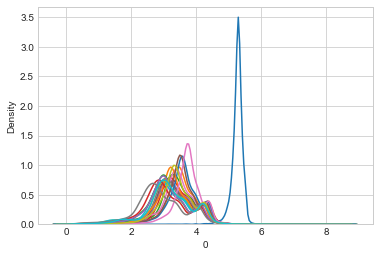

In [106]:
## plot the kde plot for sorted distance 
for i in range(20):
  sns.kdeplot(np.log(aapl_sorted_dist_df.iloc[i,:]+1))
  plt.legend('')

plt.savefig('AAPLkde.png')
plt.show()
#plt.savefig('AAPLkde.png')

In [41]:
aapl_label, aapl_label_name=doLabeling(aapl_data)

print('\nLabel for AAPL data')
print('down:', np.sum(aapl_label[0]), 'up:', np.sum(aapl_label[1]), 'equal:', np.sum(aapl_label[2]))


Label for AAPL data
down: 2909 up: 2768 equal: 173


Check their visualization under PCA and t-SNE

PCA

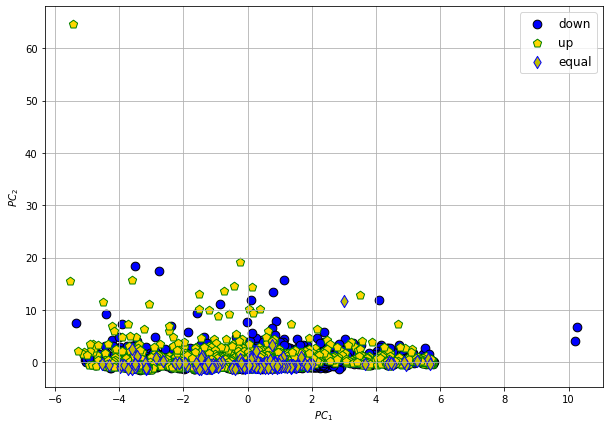

In [42]:
aapl_pcaNewData, aapl_EVR=doPCA3(aapl_data,2)

fig=plt.figure(figsize=(10,7))
biplot_ez(aapl_pcaNewData, aapl_label, aapl_label_name, 'pca')

In [43]:
#TSNE
aapl_tsne = doTSNE(aapl_data, 50, 'random') #perplexity = 50, init = random
aapl_tsne
#print ('EVR = ',evr)

array([[-22.73734  ,  11.764206 ],
       [-35.018826 ,   9.397842 ],
       [-36.257557 ,  10.0845175],
       ...,
       [-15.67109  ,  35.062637 ],
       [-15.951914 ,  24.73355  ],
       [-23.750572 ,  10.001828 ]], dtype=float32)

TSNE

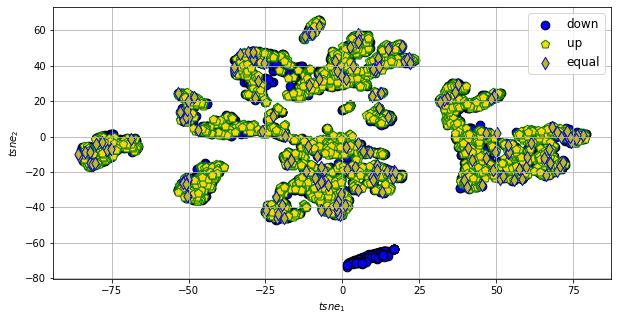

In [44]:
#biplot of TSNE of aapl
plt.figure(figsize=(10,5))
biplot_ez(aapl_tsne, aapl_label, aapl_label_name, 'tsne')

In [45]:
aapl_EVR = aapl_EVR.reshape((len(aapl_EVR),1))
print('Cumulative explained variance ratio:\n', np.cumsum(aapl_EVR))

Cumulative explained variance ratio:
 [0.37210115 0.60503632 0.76891567 0.87113803 0.95061759 0.99083285
 0.99940702 0.99993945 0.99999611 0.99999932 1.        ]


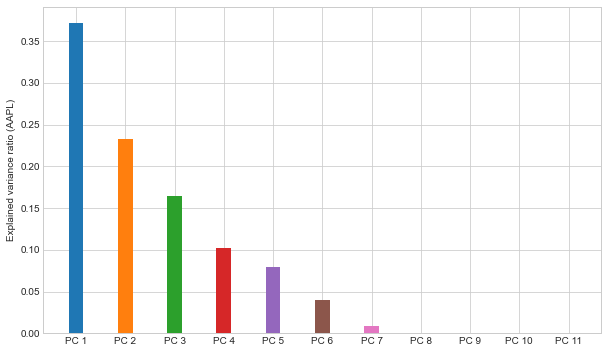

In [48]:
plotExplainedVarianceRatio(aapl_EVR)
plt.ylabel('Explained variance ratio (AAPL)')
plt.show()


In [49]:
dim_selected=-1
cum_EVR=np.cumsum(aapl_EVR)
cutoff=0.9
for k in  range(len(cum_EVR)):
  if cum_EVR[k]>=cutoff:
    dim_selected=k
    break

print('selected dim is: ', dim_selected)

selected dim is:  4


In [50]:
pca_newData=aapl_pcaNewData[:, 0: dim_selected+1]
pca_newData

array([[ 3.49611028, 12.90503864, -0.31143704, -0.82634075,  0.22820787],
       [ 4.16658107,  3.24086861, -0.73448257,  0.06650176, -0.13343502],
       [ 4.32923001,  2.47476237, -0.71577624, -0.25604855, -0.10369822],
       ...,
       [-2.07433475,  0.91032008, -0.07775739, -0.11512815, -0.43628502],
       [-2.18422953,  2.30145586, -0.05801467, -0.18020878, -0.43242886],
       [-3.08587198, 11.05362446,  0.21302221, -0.76647601, -0.48338662]])

In [51]:
pca_dist_df=calculatePairWiseDistance(pca_newData)
pca_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(pca_dist_df)

pca_top_5_nn_idx=pca_sort_dist_index_matrix_df.iloc[:, 0:6]

PCA- top 5 neighbors

In [52]:
pca_top_5_nn_idx.head()

,0,1,2,3,4,5
0,0,390,389,2730,1950,3510
1,1,6,20,18,30,226
2,2,29,226,21,20,3
3,3,21,4,5,29,2
4,4,5,3,8,21,172


Raw Data top 5 neighbors

In [53]:
top_5_nn_idx.head(5)

,0,1,2,3,4,5
0,0,390,2730,3510,1950,2340
1,1,6,20,18,30,2
2,2,20,29,6,21,3
3,3,21,4,29,5,228
4,4,3,5,21,19,22


In [57]:
#finding the intersection of the two idx matrices
#Calling merge() function
int_df = pd.merge(top_5_nn_idx, pca_top_5_nn_idx, how ='inner')
int_df

,0,1,2,3,4,5
0,52,68,48,64,63,51
1,53,56,57,74,59,72
2,56,53,72,57,74,70
3,72,56,53,57,74,70
4,76,59,67,78,46,50
...,...,...,...,...,...,...
218,5746,1498,475,5450,665,663
219,5762,5742,5748,5744,5750,5749
220,5786,5730,4955,5733,5735,5734
221,5791,5809,5671,5525,5719,4955


In [58]:
int_df.shape

(223, 6)

In [59]:
original = top_5_nn_idx.shape[0]
overlap = int_df.shape[0]
print ('Percentage of overlap = ',(overlap/original) * 100)

Percentage of overlap =  3.8119658119658117


AEO Dataset

Check nearest neighbors in the input space and the counterpart PCA space

Calculate a pairwise distance matrix

In [60]:
normalized_aeo_data=doNormalization(aeo_data,1)
aeo_dist_df=calculatePairWiseDistance(normalized_aeo_data)
print(aeo_dist_df.shape)

(5850, 5850)


Sort each row in the pairwise distance matrix to get an index matrix

In [61]:
aeo_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(aeo_dist_df)

In [62]:
aeo_sort_dist_index_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0,2340,1951,2344,10,3121,91,1961,1170,2737,...,3707,2559,3717,3718,1466,1465,5306,1464,3744,1308
1,1,490,2,393,409,2415,2350,2347,787,2465,...,1464,1465,2266,589,985,634,2249,4940,1447,2228
2,2,490,2415,404,28,21,323,2425,409,20,...,2097,634,2067,2066,2030,674,1870,1856,524,2660
3,3,9,400,2361,395,2484,15,11,2465,399,...,2066,2067,5247,2097,2128,2131,2731,2136,1439,781
4,4,1568,2342,1950,3121,1564,3145,2745,780,1560,...,4493,1017,2455,3740,519,2222,2563,2228,4680,4014


In [63]:
top_5_nn_idx = aeo_sort_dist_index_matrix_df.iloc[:, 0:6]

top_5_nn_idx.head(10)

,0,1,2,3,4,5
0,0,2340,1951,2344,10,3121
1,1,490,2,393,409,2415
2,2,490,2415,404,28,21
3,3,9,400,2361,395,2484
4,4,1568,2342,1950,3121,1564
5,5,29,403,406,404,156
6,6,35,153,3123,402,34
7,7,8,27,405,437,22
8,8,405,6,27,7,35
9,9,11,3,401,399,2465


Get the sorted distance matrix

In [64]:
aeo_sorted_dist_df=getSortedDistanceMatrix(aeo_sort_dist_index_matrix_df.values, aeo_dist_df)
aeo_sorted_dist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0.0,4.425959,4.590148,4.752138,4.818276,5.263715,5.538030,5.714854,5.839483,5.930160,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.588407,0.650506,0.717748,0.764772,0.858880,0.931252,1.072563,1.103951,1.123019,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.102479,0.248290,0.426672,0.428953,0.491199,0.502629,0.532024,0.540630,0.555231,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.351294,0.413133,0.858593,0.954504,0.982958,1.070727,1.191137,1.229475,1.296239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1.618876,2.724955,3.977315,5.530096,5.759929,5.785525,5.884020,6.521215,7.177641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.0,0.223862,0.227200,0.231684,0.251138,0.391996,0.397161,0.397654,0.408825,0.413789,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.0,0.129405,0.279435,0.373189,0.378792,0.482501,0.485737,0.595774,0.692278,0.704239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.496346,0.612739,0.783158,0.929571,1.059545,1.358481,1.487493,1.488928,1.529366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.0,0.229854,0.485737,0.487305,0.496346,0.698539,0.787853,1.041237,1.166393,1.208967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.337123,0.351294,0.471807,0.543586,0.604592,0.706569,0.785989,0.866631,0.868577,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


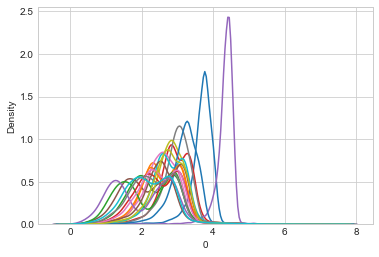

In [65]:
## plot the kde plot for sorted distance 
for i in range(20):
  sns.kdeplot(np.log(aeo_sorted_dist_df.iloc[i,:]+1))
  plt.legend('')
    
plt.savefig('AEOkde.png')
plt.show()

In [66]:
aeo_label, aeo_label_name = doLabeling(aeo_data)

print('\nLabel for AEO data')
print('down:', np.sum(aeo_label[0]), 'up:', np.sum(aeo_label[1]), 'equal:', np.sum(aeo_label[2]))


Label for AEO data
down: 2384 up: 2297 equal: 1169


PCA

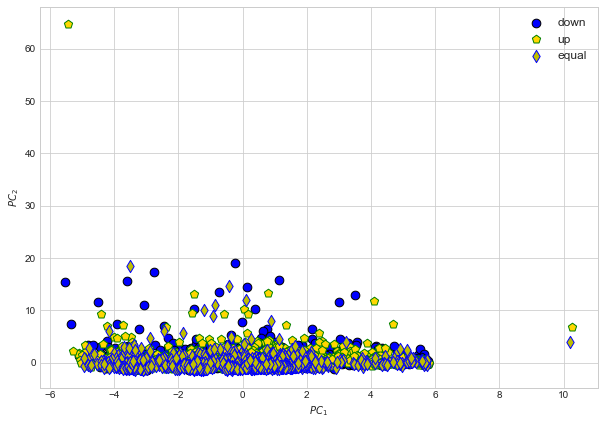

In [67]:
aeo_pcaNewData, aeo_EVR=doPCA3(aapl_data,2)

fig=plt.figure(figsize=(10,7))
biplot_ez(aeo_pcaNewData, aeo_label, aeo_label_name, 'pca')

In [68]:
#aeo_data

TSNE

In [69]:
#TSNE
aeo_tsne = doTSNE(aeo_data, 100, 'random') #perplexity = 50, init = random
aeo_tsne

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [70]:
#biplot of TSNE of aeo
plt.figure(figsize=(10,5))
biplot_ez(aeo_tsne, aeo_label, aeo_label_name, 'tsne')

NameError: name 'aeo_tsne' is not defined

<Figure size 720x360 with 0 Axes>

In [71]:
aeo_EVR = aeo_EVR.reshape((len(aeo_EVR),1))
print('Cumulative explained variance ratio:\n', np.cumsum(aeo_EVR))

Cumulative explained variance ratio:
 [0.37210115 0.60503632 0.76891567 0.87113803 0.95061759 0.99083285
 0.99940702 0.99993945 0.99999611 0.99999932 1.        ]


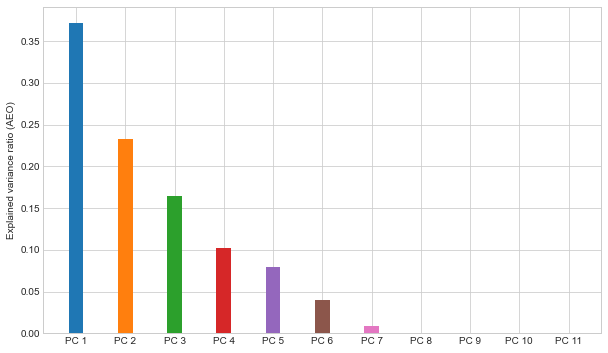

In [72]:
plotExplainedVarianceRatio(aeo_EVR)
plt.ylabel('Explained variance ratio (AEO)')
plt.show()


In [73]:
dim_selected=-1
cum_EVR=np.cumsum(aeo_EVR)
cutoff=0.9
for k in  range(len(cum_EVR)):
  if cum_EVR[k]>=cutoff:
    dim_selected=k
    break

print('selected dim is: ', dim_selected)

selected dim is:  4


In [74]:
pca_newData = aeo_pcaNewData[:, 0: dim_selected+1]
pca_newData

array([[ 3.49611028, 12.90503864, -0.31143704, -0.82634075,  0.22820787],
       [ 4.16658107,  3.24086861, -0.73448257,  0.06650176, -0.13343502],
       [ 4.32923001,  2.47476237, -0.71577624, -0.25604855, -0.10369822],
       ...,
       [-2.07433475,  0.91032008, -0.07775739, -0.11512815, -0.43628502],
       [-2.18422953,  2.30145586, -0.05801467, -0.18020878, -0.43242886],
       [-3.08587198, 11.05362446,  0.21302221, -0.76647601, -0.48338662]])

In [75]:
pca_dist_df = calculatePairWiseDistance(pca_newData)
pca_sort_dist_index_matrix_df = sortEachRowOfPairwiseDistanceMatrix(pca_dist_df)

pca_top_5_nn_idx = pca_sort_dist_index_matrix_df.iloc[:, 0:6]

PCA

In [76]:
pca_top_5_nn_idx.head()

,0,1,2,3,4,5
0,0,390,389,2730,1950,3510
1,1,6,20,18,30,226
2,2,29,226,21,20,3
3,3,21,4,5,29,2
4,4,5,3,8,21,172


Raw Data

In [77]:
top_5_nn_idx.head(5)

,0,1,2,3,4,5
0,0,2340,1951,2344,10,3121
1,1,490,2,393,409,2415
2,2,490,2415,404,28,21
3,3,9,400,2361,395,2484
4,4,1568,2342,1950,3121,1564


In [78]:
#finding the intersection of the two idx matrices
#Calling merge() function
int_df = pd.merge(top_5_nn_idx, pca_top_5_nn_idx, how ='inner')
int_df

,0,1,2,3,4,5


In [79]:
original = top_5_nn_idx.shape[0]
overlap = int_df.shape[0]
print ('Percentage of overlap = ',(overlap/original) * 100)

Percentage of overlap =  0.0


BAC Dataset

Check nearest neighbors in the input space and the counterpart PCA space

Calculate a pairwise distance matrix

In [80]:
normalized_bac_data=doNormalization(bac_data,1)
bac_dist_df=calculatePairWiseDistance(normalized_bac_data)
print(bac_dist_df.shape)

(5850, 5850)


Sort each row in the pairwise distance matrix to get an index matrix

In [81]:
bac_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(bac_dist_df)

In [82]:
bac_sort_dist_index_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0,3510,4290,2339,390,2730,1562,3120,3197,1559,...,2939,1651,1745,1835,5720,1834,4170,3900,4171,892
1,1,1568,22,1564,1572,7,31,1565,11,896,...,1651,4287,3508,4170,4171,389,1169,5460,892,3900
2,2,24,1220,273,22,905,2716,1284,904,25,...,1835,1834,1651,4170,4171,389,1169,5460,892,3900
3,3,1565,22,36,1572,2733,2,3109,1,24,...,1651,1835,1834,4170,4171,389,1169,5460,892,3900
4,4,18,2778,431,2776,1220,2789,3109,445,2733,...,1835,1651,1834,4170,4171,389,1169,5460,892,3900


In [83]:
top_5_nn_idx = bac_sort_dist_index_matrix_df.iloc[:, 0:6]

top_5_nn_idx.head(10)

,0,1,2,3,4,5
0,0,3510,4290,2339,390,2730
1,1,1568,22,1564,1572,7
2,2,24,1220,273,22,905
3,3,1565,22,36,1572,2733
4,4,18,2778,431,2776,1220
5,5,3119,3905,46,2734,3507
6,6,3118,2763,2740,1170,2734
7,7,3901,1186,3104,16,11
8,8,1199,13,172,2774,1221
9,9,2794,14,3902,1171,2791


Get the sorted distance matrix

In [84]:
bac_sorted_dist_df = getSortedDistanceMatrix(bac_sort_dist_index_matrix_df.values, bac_dist_df)
bac_sorted_dist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0.0,3.848931,6.436529,7.173953,7.762707,8.152276,9.688341,11.788534,13.358959,14.705304,...,306.070895,306.378265,320.022184,336.730068,341.254793,347.903881,413.372236,421.017036,432.263524,740.452853
1,0.0,0.679538,1.058101,1.317831,1.385597,1.624786,1.669599,1.678725,1.723718,1.745655,...,209.598095,228.255202,232.372437,289.011557,298.316821,443.793729,467.375684,603.843478,611.010143,821.747879
2,0.0,0.187772,0.420353,0.955716,0.999487,1.120941,1.301772,1.390439,1.440198,1.469427,...,240.802726,244.769748,245.162981,329.932458,339.210790,429.283686,444.583168,573.214479,670.190757,777.312551
3,0.0,0.771152,0.807547,1.003683,1.539111,1.783779,1.795615,1.832017,1.863676,1.863681,...,221.618431,221.984502,226.875769,303.155332,314.011118,397.313120,416.778819,546.579261,629.913690,757.324547
4,0.0,0.437585,0.456270,0.588713,0.590148,0.643455,0.734318,0.738521,0.934325,1.125017,...,263.133058,264.386197,268.032005,348.422498,359.830050,400.958817,423.358029,560.613235,700.203423,774.036982
5,0.0,2.123518,2.511981,2.971724,3.389448,3.566753,3.968821,4.509942,4.529546,4.782083,...,279.895513,291.480677,292.323493,301.233066,303.345021,366.391404,384.665928,442.982667,661.217831,709.056399
6,0.0,1.695077,1.919004,2.025370,2.180944,2.500241,2.834080,2.860833,3.061556,3.137747,...,254.846921,260.210154,267.555344,313.805165,328.430133,331.135595,343.191841,455.249924,663.253330,665.284914
7,0.0,0.992058,1.268423,1.347472,1.354098,1.385132,1.393439,1.480163,1.490314,1.492577,...,229.808538,234.786784,237.433046,296.124953,304.342808,462.169651,476.052063,604.666865,633.972477,819.113514
8,0.0,0.125768,0.171799,0.172761,0.186154,0.191158,0.214703,0.231934,0.260589,0.268086,...,254.775419,272.791873,274.011934,325.939818,332.517551,512.885117,529.065720,664.722722,676.422458,880.108482
9,0.0,0.235767,0.358320,0.565077,0.580171,0.638477,0.646134,0.653943,0.890512,0.891053,...,272.860256,298.950235,298.971808,302.958159,304.351522,549.824076,567.979746,639.354328,705.570810,930.059991


In [85]:
bac_sorted_dist_df.shape

(5850, 5850)

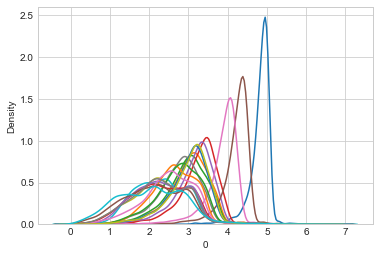

In [86]:
## plot the kde plot for sorted distance 
for i in range(20):
  sns.kdeplot(np.log(bac_sorted_dist_df.iloc[i,:]+1))
  plt.legend('')
plt.savefig('BACkde.png')
plt.show()

In [87]:
bac_label, bac_label_name=doLabeling(bac_data)

print('\nLabel for BAC data')
print('down:', np.sum(bac_label[0]), 'up:', np.sum(bac_label[1]), 'equal:', np.sum(bac_label[2]))


Label for BAC data
down: 2376 up: 2666 equal: 808


PCA

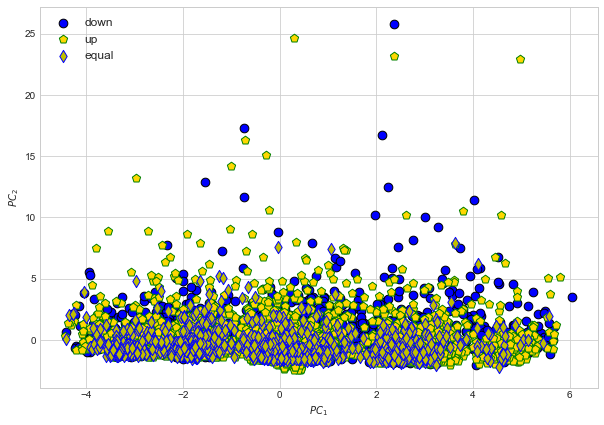

In [88]:
bac_pcaNewData, bac_EVR=doPCA3(bac_data,2)

fig=plt.figure(figsize=(10,7))
biplot_ez(bac_pcaNewData, bac_label, bac_label_name, 'pca')

In [89]:
#TSNE
bac_tsne = doTSNE(bac_data, 50, 'random') #perplexity = 50, init = random
print (bac_tsne)
#print ('EVR = ',evr)

[[-13.67139    -2.8305922]
 [ -6.5399656   4.2880898]
 [ -5.271266    3.4093635]
 ...
 [ -0.893364  -22.495234 ]
 [ -8.107167   -9.5222435]
 [-13.6305275  -4.7560124]]


TSNE

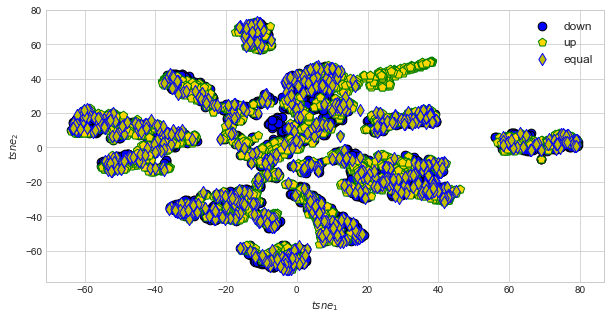

In [90]:
#biplot of TSNE of aapl
plt.figure(figsize=(10,5))
biplot_ez(bac_tsne, bac_label, bac_label_name, 'tsne')

In [91]:
bac_EVR = bac_EVR.reshape((len(bac_EVR),1))
print('Cumulative explained variance ratio:\n', np.cumsum(bac_EVR))

Cumulative explained variance ratio:
 [0.48671997 0.74639871 0.83719613 0.92241911 0.98308885 0.99953511
 0.99983588 0.99996014 0.99999353 0.99999993 1.        ]


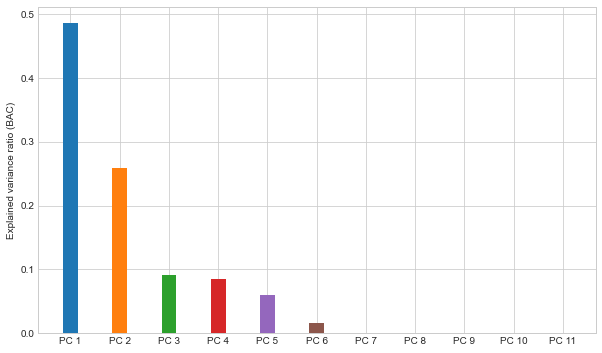

In [92]:
plotExplainedVarianceRatio(bac_EVR)
plt.ylabel('Explained variance ratio (BAC)')
plt.show()


In [93]:
dim_selected=-1
cum_EVR = np.cumsum(bac_EVR)
cutoff=0.9
for k in  range(len(cum_EVR)):
  if cum_EVR[k]>=cutoff:
    dim_selected=k
    break

print('selected dim is: ', dim_selected)

selected dim is:  3


In [94]:
pca_newData = bac_pcaNewData[:, 0: dim_selected+1]
pca_newData

array([[ 1.97581747, 10.21904402,  0.74540944, -0.28414746],
       [ 1.54434136,  2.80170939, -0.7159365 ,  1.20125   ],
       [ 1.52685805,  2.86473607,  0.34994917,  0.27754051],
       ...,
       [-1.6430296 ,  2.63042549, -0.04779822, -0.58445277],
       [-1.43979555,  4.91674151,  1.0217811 , -0.65288874],
       [-0.74346963, 11.63286343,  1.26783263, -1.31949238]])

In [95]:
pca_dist_df = calculatePairWiseDistance(pca_newData)
pca_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(pca_dist_df)

pca_top_5_nn_idx=pca_sort_dist_index_matrix_df.iloc[:, 0:5]

PCA

In [96]:
pca_top_5_nn_idx.head()

,0,1,2,3,4
0,0,30,3899,3510,2339
1,1,22,1568,896,1563
2,2,24,1220,905,420
3,3,1565,22,36,2733
4,4,2778,431,18,445


Raw Data

In [97]:
top_5_nn_idx.head(5)

,0,1,2,3,4,5
0,0,3510,4290,2339,390,2730
1,1,1568,22,1564,1572,7
2,2,24,1220,273,22,905
3,3,1565,22,36,1572,2733
4,4,18,2778,431,2776,1220


In [98]:
#finding the intersection of the two idx matrices
#Calling merge() function
int_df = pd.merge(top_5_nn_idx, pca_top_5_nn_idx, how ='inner')
int_df

,0,1,2,3,4,5
0,304,329,278,283,315,279
1,396,397,398,395,482,402
2,399,402,401,403,404,442
3,400,575,5739,661,602,5755
4,401,399,402,404,403,442
...,...,...,...,...,...,...
167,5552,5734,5733,5731,4382,4381
168,5611,5630,5588,5608,5802,5706
169,5733,5734,5552,5731,4382,4381
170,5734,5733,5552,5731,4382,4381


In [99]:
original = top_5_nn_idx.shape[0]
overlap = int_df.shape[0]
print ('Percentage of overlap = ',(overlap/original) * 100)

Percentage of overlap =  2.9401709401709404


WMT Dataset

Check nearest neighbors in the input space and the counterpart PCA space

Calculate a pairwise distance matrix

In [100]:
normalized_wmt_data=doNormalization(wmt_data,1)
wmt_dist_df=calculatePairWiseDistance(normalized_wmt_data)
print(wmt_dist_df.shape)

(5850, 5850)


Sort each row in the pairwise distance matrix to get an index matrix

In [101]:
wmt_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(wmt_dist_df)

In [102]:
wmt_sort_dist_index_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0,4680,1169,389,1,12,5065,4703,5460,779,...,4355,4865,476,4564,474,4381,4475,469,470,4290
1,1,2,5,4,12,8,7,2339,6,30,...,4564,4381,448,4475,476,474,3900,469,470,4290
2,2,8,11,7,1,4282,9,2015,2340,1560,...,4475,448,476,4289,4291,474,3900,469,470,4290
3,3,387,30,2337,29,385,388,4,2338,24,...,4865,4291,4564,4355,4381,4475,3900,469,470,4290
4,4,29,6,5,12,30,3,2339,2337,385,...,474,4865,4564,4355,4381,4475,3900,469,470,4290


In [103]:
top_5_nn_idx=aapl_sort_dist_index_matrix_df.iloc[:, 0:6]

top_5_nn_idx.head(10)

,0,1,2,3,4,5
0,0,390,2730,3510,1950,2340
1,1,6,20,18,30,2
2,2,20,29,6,21,3
3,3,21,4,29,5,228
4,4,3,5,21,19,22
5,5,21,7,29,3,4
6,6,20,1,2,387,18
7,7,5,29,21,391,161
8,8,172,28,9,32,23
9,9,23,28,22,32,8


Get the sorted distance matrix

In [104]:
wmt_sorted_dist_df=getSortedDistanceMatrix(wmt_sort_dist_index_matrix_df.values, wmt_dist_df)
wmt_sorted_dist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,5840,5841,5842,5843,5844,5845,5846,5847,5848,5849
0,0.0,36.438233,43.480402,44.214958,49.263919,51.239147,52.243384,52.280498,54.719455,55.573324,...,457.659414,463.707099,485.011286,494.318060,519.617647,533.217747,547.995996,761.369577,776.359451,990.560222
1,0.0,16.470678,21.573004,25.070572,33.606278,33.798511,33.989552,34.383503,35.924483,39.085624,...,330.968717,364.931433,369.821186,380.369217,392.522294,428.335046,495.852327,663.048408,674.349825,1324.510227
2,0.0,5.255795,9.797920,12.349347,16.470678,39.981885,43.443319,44.178797,45.900373,45.901330,...,278.620180,352.556363,368.278748,378.854984,381.462575,407.883564,577.821889,641.509183,649.245564,1515.076291
3,0.0,2.371740,2.747197,3.027197,3.089800,3.439887,4.032984,4.925434,5.525429,5.787212,...,415.466409,426.155010,461.554660,485.272571,523.054655,539.321639,542.888470,573.900267,581.572199,1546.272424
4,0.0,3.328048,3.660925,3.883334,4.344421,4.622878,4.925434,5.251413,7.322915,8.079798,...,378.143757,404.423632,452.225636,461.892396,506.645274,524.133618,541.634002,620.450330,629.734348,1478.702417
5,0.0,2.336264,3.883334,4.930708,5.100317,10.030247,13.423931,16.073975,16.391849,16.572264,...,425.438904,436.542077,469.287477,474.049014,513.995449,523.276759,541.945729,687.115724,698.329350,1382.034087
6,0.0,2.336264,2.358052,3.157877,3.660925,5.352336,10.464897,11.202471,11.540856,11.991309,...,431.159834,464.812248,511.686700,515.842997,532.965206,566.982843,586.193031,685.305389,695.850962,1433.797859
7,0.0,12.349347,13.457353,13.593019,33.989552,48.778257,54.492166,63.058883,74.558535,76.561988,...,349.088269,356.581192,391.252523,425.822924,468.202316,507.549683,599.353086,745.731196,754.977529,1459.606553
8,0.0,1.052714,5.255795,13.593019,28.254989,28.747882,33.798511,38.948332,40.965793,42.785825,...,275.218276,356.306546,372.038153,413.570248,444.800880,457.057994,647.873897,653.790315,689.226965,1672.958562
9,0.0,4.837064,6.153956,6.908937,6.967746,7.814914,8.445918,8.659425,8.823149,9.039061,...,376.597206,399.930034,420.066872,434.038778,441.719368,509.347590,632.676710,637.198097,670.439275,1758.015162


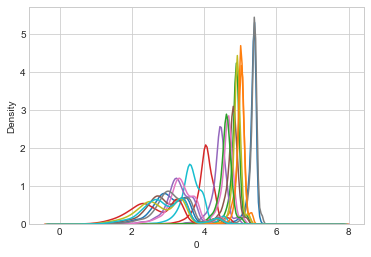

In [105]:
## plot the kde plot for sorted distance 
for i in range(20):
  sns.kdeplot(np.log(wmt_sorted_dist_df.iloc[i,:]+1))
  plt.legend('')
plt.savefig('WMTkde.png')
plt.show()

In [282]:
wmt_label, wmt_label_name=doLabeling(aapl_data)

print('\nLabel for wmt data')
print('down:', np.sum(wmt_label[0]), 'up:', np.sum(wmt_label[1]), 'equal:', np.sum(wmt_label[2]))


Label for wmt data
down: 2909 up: 2768 equal: 173


PCA

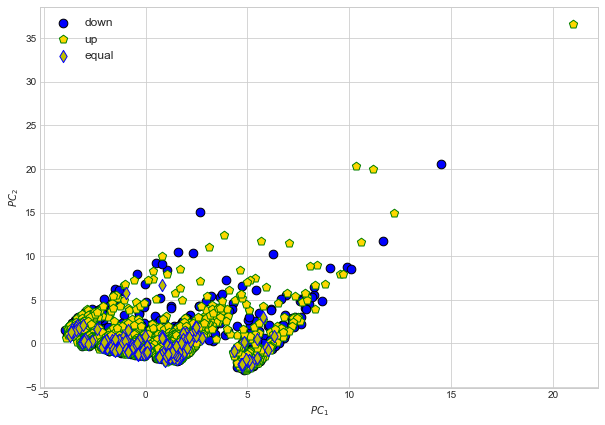

In [283]:
wmt_pcaNewData, wmt_EVR=doPCA3(wmt_data,2)

fig=plt.figure(figsize=(10,7))
biplot_ez(wmt_pcaNewData, wmt_label, wmt_label_name, 'pca')

In [284]:
#TSNE
wmt_tsne = doTSNE(wmt_data, 50, 'random') #perplexity = 50, init = random
print (wmt_tsne)
#print ('EVR = ',evr)

[[31.375816  15.577132 ]
 [12.831732  25.90687  ]
 [15.716239   5.209551 ]
 ...
 [37.41931   -6.6790314]
 [36.367355  13.200311 ]
 [34.96048   15.784116 ]]


TSNE

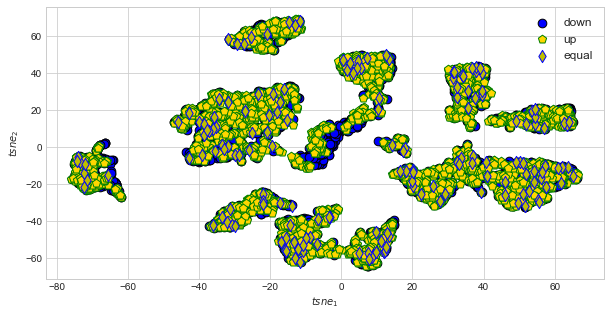

In [285]:
#biplot of TSNE of aapl
plt.figure(figsize=(10,5))
biplot_ez(wmt_tsne, wmt_label, wmt_label_name, 'tsne')

In [286]:
wmt_EVR = wmt_EVR.reshape((len(wmt_EVR),1))
print('Cumulative explained variance ratio:\n', np.cumsum(wmt_EVR))

Cumulative explained variance ratio:
 [0.50274574 0.73983143 0.83139561 0.91267364 0.98675075 0.99985746
 0.99994172 0.99998039 0.99999598 0.99999987 1.        ]


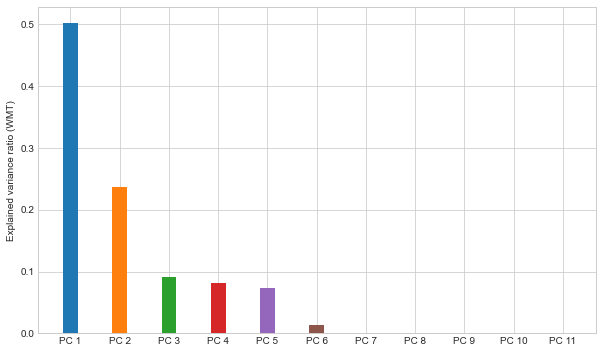

In [287]:
plotExplainedVarianceRatio(wmt_EVR)
plt.ylabel('Explained variance ratio (WMT)')
plt.show()


In [288]:
dim_selected=-1
cum_EVR=np.cumsum(wmt_EVR)
cutoff=0.9
for k in  range(len(cum_EVR)):
  if cum_EVR[k]>=cutoff:
    dim_selected=k
    break

print('selected dim is: ', dim_selected)

selected dim is:  3


In [290]:
pca_newData=wmt_pcaNewData[:, 0: dim_selected+1]
pca_newData

array([[ 3.82541374, 12.461154  , -0.16189849,  2.2774236 ],
       [ 2.33330959, 10.40276147, -0.06973833,  4.12718784],
       [ 1.03500948,  8.43922018, -0.5374572 ,  5.49721251],
       ...,
       [ 2.61904042,  1.62121759,  0.81034529, -0.54791441],
       [ 3.64571603,  4.0523452 , -0.24383837, -0.94657119],
       [ 4.9898907 ,  7.01894524, -0.32205632, -0.95132237]])

In [291]:
pca_dist_df=calculatePairWiseDistance(pca_newData)
pca_sort_dist_index_matrix_df=sortEachRowOfPairwiseDistanceMatrix(pca_dist_df)

pca_top_5_nn_idx=pca_sort_dist_index_matrix_df.iloc[:, 0:5]

PCA

In [292]:
pca_top_5_nn_idx.head()

,0,1,2,3,4
0,0,1169,3509,1,5
1,1,2,0,7,1169
2,2,8,11,1,7
3,3,2337,387,30,29
4,4,779,12,6,29


Raw Data

In [293]:
top_5_nn_idx.head(5)

,0,1,2,3,4,5
0,0,390,2730,3510,1950,2340
1,1,6,20,18,30,2
2,2,20,29,6,21,3
3,3,21,4,29,5,228
4,4,3,5,21,19,22


In [294]:
#finding the intersection of the two idx matrices
#Calling merge() function
int_df = pd.merge(top_5_nn_idx, pca_top_5_nn_idx, how ='inner')
int_df

,0,1,2,3,4,5


In [295]:
int_df.shape

(0, 6)

In [296]:
original = top_5_nn_idx.shape[0]
overlap = int_df.shape[0]
print ('Percentage of overlap = ',(overlap/original) * 100)

Percentage of overlap =  0.0


Part 4- Implement SVD and use it to find the important samples in each HFT data

In [62]:
#The SVD function
from sklearn.decomposition import randomized_svd

def doSVD(data):
    U, Sigma, VT = randomized_svd(data, 
                              n_components=10,
                              n_iter=5,
                              random_state=None)
    return U, Sigma, VT

In [158]:
def dorankFeatures(data):
    data = data.iloc[:, 2:]
    data_np = data.to_numpy() #convert pd to np array
    
    #implement SVD
    U,sigma,VT = doSVD(data_np)
    n = VT.shape[0]
    print ("Number of columns after SVD = ",n)
    
    #Rank the features
    U = pd.DataFrame(data = U)
    U['Ranking'] = U.apply(lambda x: np.sqrt(x.dot(x)), axis=1)
    ranking = U.Ranking.sort_values(ascending=False)[0:10]
    print ('\n')
    print ('Top 10 Ranked Features')
    print ('Feature'+'  '+'Rank Score')
    print (ranking)

In [159]:
filename=['AAPL_n.csv', 'AEO_n.csv', 'BAC_n.csv','WMT_n.csv']

aapl_pd = pd.read_csv(filename[0])
aapl_pd.head(5)

,Unnamed: 0,Date,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume
0,0,2/1/2019 9:30,167.058,0.000000,167.150,167.55,166.67,1.319461e+08,1766,166.93,789821
1,1,2/1/2019 9:31,167.182,0.000742,167.175,167.42,166.80,2.853055e+07,1143,167.21,170656
2,2,2/1/2019 9:32,167.051,-0.000042,166.910,167.20,166.88,2.232776e+07,1016,167.17,133658
3,3,2/1/2019 9:33,166.945,-0.000676,166.958,167.11,166.77,2.014459e+07,839,166.97,120666
4,4,2/1/2019 9:34,167.045,-0.000078,167.180,167.19,166.92,1.707804e+07,843,166.96,102236


In [160]:
dorankFeatures(aapl_pd)

Number of columns after SVD =  9


Top 10 Ranked Features
Feature  Rank Score
3900    0.789289
1768    0.467182
1810    0.467092
1035    0.451104
857     0.315211
948     0.302954
1170    0.285306
0       0.285229
1771    0.284778
1895    0.284043
Name: Ranking, dtype: float64


In [161]:
aeo_pd = pd.read_csv(filename[1])
aeo_pd.head(5)

,Unnamed: 0,Date,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume
0,0,2/1/2019 9:30,21.117,0.000000,21.04,21.12,21.00,367113.8300,10,21.12,17385
1,1,2/1/2019 9:31,21.075,-0.001989,21.05,21.10,21.04,7334.1660,6,21.10,348
2,2,2/1/2019 9:32,21.083,-0.001610,21.06,21.10,21.05,61373.6900,31,21.08,2911
3,3,2/1/2019 9:33,21.092,-0.001184,21.13,21.13,21.05,66609.1445,27,21.08,3158
4,4,2/1/2019 9:34,21.050,-0.003173,21.01,21.14,20.97,322673.6164,116,21.14,15329


In [162]:
dorankFeatures(aeo_pd)

Number of columns after SVD =  9


Top 10 Ranked Features
Feature  Rank Score
1054    0.501813
2565    0.500659
1392    0.499846
2647    0.498167
831     0.451240
1125    0.430413
4717    0.345285
1246    0.325087
4679    0.276650
1569    0.265176
Name: Ranking, dtype: float64


In [163]:
bac_pd = pd.read_csv(filename[2])
bac_pd.head(5)

,Unnamed: 0,Date,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume
0,0,2/1/2019 9:30,28.599,0.000000,28.560,28.62,28.530,2.746211e+07,1072,28.60,960229
1,1,2/1/2019 9:31,28.544,-0.001923,28.530,28.62,28.510,7.730019e+06,739,28.56,270815
2,2,2/1/2019 9:32,28.544,-0.001923,28.568,28.58,28.520,9.587057e+06,607,28.53,335871
3,3,2/1/2019 9:33,28.559,-0.001399,28.595,28.62,28.521,1.048060e+07,809,28.57,366985
4,4,2/1/2019 9:34,28.593,-0.000210,28.610,28.62,28.580,9.773605e+06,884,28.60,341820


In [164]:
dorankFeatures(bac_pd)

Number of columns after SVD =  9


Top 10 Ranked Features
Feature  Rank Score
602     0.537481
3900    0.528405
5720    0.489469
892     0.452090
5460    0.385527
1651    0.350732
1834    0.344501
1835    0.343322
1745    0.335098
4171    0.322749
Name: Ranking, dtype: float64


In [165]:
wmt_pd = pd.read_csv(filename[3])
wmt_pd.head(5)

,Unnamed: 0,Date,marketAverage,marketChangeOverTime,marketClose,marketHigh,marketLow,marketNotional,marketNumberOfTrades,marketOpen,marketVolume
0,0,2/1/2019 9:30,95.850,0.000000,95.63,96.00,95.330,24175968.31,686,95.92,252227
1,1,2/1/2019 9:31,95.148,-0.007324,94.91,95.92,94.842,13879033.35,1046,95.61,145868
2,2,2/1/2019 9:32,94.683,-0.012175,94.57,95.92,94.530,10984547.98,619,94.92,116014
3,3,2/1/2019 9:33,94.578,-0.013271,94.50,94.70,94.470,10218791.00,690,94.62,108046
4,4,2/1/2019 9:34,94.298,-0.016192,94.26,94.51,94.130,10836263.32,956,94.50,114915


In [157]:
dorankFeatures(wmt_pd)

Number of columns after SVD =  9


Top 10 Ranked Features
Feature   Rank Score
4290    0.555745
3900    0.554504
4865    0.473929
4950    0.446760
4475    0.398382
4381    0.391958
3782    0.381101
4355    0.375967
4564    0.362288
271     0.336358
Name: Ranking, dtype: float64
